# Machine learning: Final Project

## Authors: Maximilian Janisch and Marco Bertenghi

# Problem Description

We have been assigned a multi-class classification problem, that is we are interested in correctly predicting if a given input in $\mathcal{X} = \mathbb{R}^d$ belongs to one of __three__ classes (i.e. $\mathcal{Y} = \{0,1,2\}$). We are instructed to solve this multi-class classification problem by reducing it to a sequence of binary classification problems (i.e. where $\mathcal{Y}'=\{0,1\}$). We are __not__ allowed to use the multi-class implementation of sklearn and one of the models we must implement must be the random forest model. The goal of the project is then to describe and document in detail how to find and implement the best machine learning algorithm for the dataset assigned to us.


We are given a __E-SCOOTER DATASET__. The dataset contains data about the profitability of e-scooter companies. The goal is to predict, as well as possible, the profitability of e-scooter companies by using the information provided. The dataset comes as a csv file (comma-separated values file), named dataset20.csv and contains the following description:

__E-SCOOTER DATASET__

----------------------------------------------

__Dataset description__:
The data is compiled from cities, towns, and small villages in Germany, Austria, and Switzerland, classified according to the profitability of e-scooter companies active in that location. There are __thirteen different features__ associated with each location. The goal is to predict the profitability of an e-scooter company (feature "class") from the other features.

__Attention!__
Please notice that the data has been artificially generated. The dataset does not reflect real-world statistical correlations between features and labels.

	Number of samples: 500
	Number of features: 13 (numeric and strings) + one column of class labels (0,1,2)
	Features description:
		pub_trans: public transport index
		price: price to rent per km
		temperature: average tempereture during summer
		inhabitants: number of inhabitants
		registered: number of registered users in thousand
		country: country
		id: internal dataset code
		nr_counterparts: nr_counterparts
		cars: number of cars per inhabitant
		labour_cost: average labour cost in thousand per month
		humidity: absolute humidity in g/m3
		windspeed: average wind speed in km/h
		size: size of city center in km2
		class: profitability (0 = loss, 1 = balanced, 2 = profit) <--- LABEL TO PREDICT

----------------------------------------


We notice that:

+ We have a total of 500 samples.
+ We have a total of 13 features.
 + Not all features will be relevant, more on that later.
+ The profitability is a class, it is the label we want to predict.
+ The CSV file uses ';' as a delimiter.

# Reading in the data

In [1]:
# Preliminary code, libraries we want to load
import os
import csv

import numpy as np
from scipy.stats import describe  # for exploratory data analysis
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import OrdinalEncoder

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV  # for hyperparameter optimization using GridSearch

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis  # im Moment nicht verwendet

from RandomForestImplementation.randomForest import RandomForestClassifier
from RandomForestImplementation.multiclass import OneVsOneClassifier

In [2]:
# Preliminary code, global variables
## ToDo: At the end this datafile can be assumed to be in the same directory as the Jupyter Notebook?
DATA_FILE = os.path.join("data", "dataset20.csv")
CLASSES = ["0 = loss", "1 = balanced", "2 = profit"]

We read in the data as follows:

In [3]:
with open(DATA_FILE, 'r') as f:
    data = csv.reader(f, delimiter = ";")

    row = data.__next__()
    rows = [row for row in data]
    features_names = np.array(row)
    CATEGORICAL_COLUMNS = [5, 6, 7]  # these are the columns "country", "id" and "nr_counterparts" which don't contain numerical data
    
    x = np.array([row[0:13] for row in rows])  # we put all the features in the x vector
    y = np.array([row[13] for row in rows]).astype(int)  # the labels go to the y vector

We will convert the categorical values to ordinals. This is a bit dangerous because the ordinals have a natural ordering which provides incorrect information about our classifications. However, it doesn't make a difference for the plots or the f-tests.

In [4]:
x = np.where(x == "", np.nan, x)  # This replaces all missing data (imported as "") by numpy NaNs. We will get back to missing data during data preprocessing
ordinalEnc = OrdinalEncoder()
x[:, CATEGORICAL_COLUMNS] = ordinalEnc.fit_transform(x[:, CATEGORICAL_COLUMNS])  # ordinal encoding of the categorical columns
x = x.astype(float)

As a brief sanity check: We can have a look at the feature names and the first representative in x.

In [5]:
print("We have the following features: \n", features_names)
print("--------------------------------")
print("The first row looks as follows: \n", x[0,:])
print("--------------------------------")
print("The first row has class label :\n", y[0])

We have the following features: 
 ['pub_trans' 'price' 'temperature' 'inhabitants' 'registered' 'country'
 'id' 'nr_counterparts' 'cars' 'labour_cost' 'humidity' 'windspeed' 'size'
 'class']
--------------------------------
The first row looks as follows: 
 [1.42026351e+01 1.90186463e-02 2.51751307e+01 2.35528166e+00
 1.18021208e+02 1.00000000e+00 4.25000000e+02 0.00000000e+00
 4.13613819e-01 2.23781367e+00 2.66531063e+00 2.83177019e+00
 7.48581880e-01]
--------------------------------
The first row has class label :
 2


Here is the shape of our data:

In [6]:
print("Shape of the features: \n", x.shape)  # Sanity check, to see what our data looks like.
print("Shape of the labels: \n", y.shape)

Shape of the features: 
 (499, 13)
Shape of the labels: 
 (499,)


# Data preprocessing

### Quick Exploratory data Analysis

To get a first feel for the data,  we shall perform a quick exploratory data analysis:

In [7]:
print("Some statistics about the feature:\n", describe(x), "\n")
print("Some statistics about the labels:\n", describe(y))

Some statistics about the feature:
 DescribeResult(nobs=499, minmax=(array([ 1.00903830e+01, -1.63896745e+00,  1.00091879e+01,             nan,
        5.50287892e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.05304206e-02,  1.68637994e+00,  1.73609293e-01, -7.05263773e-01,
                   nan]), array([ 15.22558077,   6.37403329,  28.63824462,          nan,
       153.68688064,   2.        , 498.        ,   2.        ,
         0.71789401,   3.58574164,   4.00397686,   4.95269995,
                nan])), mean=array([ 12.61764864,   1.94302811,  19.90088112,          nan,
       100.54106569,   0.98396794, 249.        ,   0.59719439,
         0.35930718,   2.52091036,   2.29087198,   2.08521068,
                nan]), variance=array([1.05828005e+00, 2.65662995e+00, 1.34000749e+01,            nan,
       1.99779052e+02, 6.66409123e-01, 2.07916667e+04, 7.30996129e-01,
       1.47837455e-02, 8.55705231e-02, 3.91051186e-01, 1.02152745e+00,
                  nan]), ske

As we can see from the following histogram, we have three classes with approximately the same number of elements:

(array([168.,   0., 176.,   0., 155.]),
 array([-0.25,  0.25,  0.75,  1.25,  1.75,  2.25]),
 <a list of 5 Patch objects>)

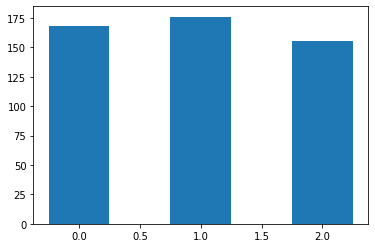

In [8]:
plt.hist(y, bins=[-0.25, 0.25, 0.75, 1.25, 1.75, 2.25])

Next we will implement [Box plots](https://en.wikipedia.org/wiki/Box_plot), a common type of data visualisation, for all our features:

C:\Users\marco\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\marco\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\marco\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\marco\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\marco\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
C:\Users\marco\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\marco\Anaconda3\lib\site-packages

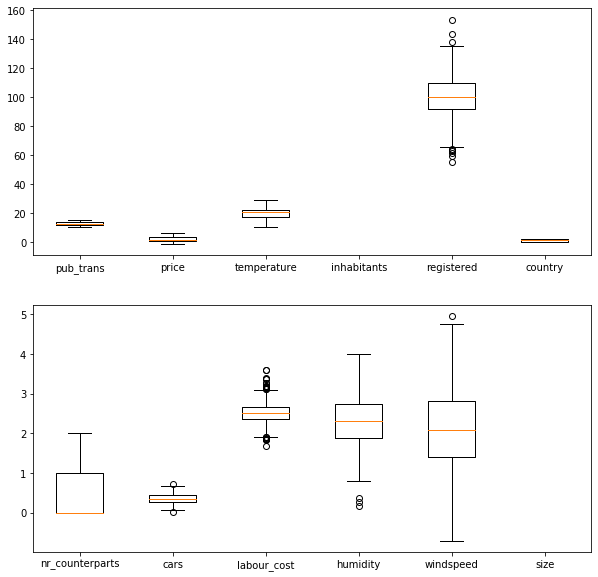

In [9]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
out1 = plt.boxplot(x[:, 0:6], labels=features_names[:6])
plt.subplot(2, 1, 2)
out2 = plt.boxplot(x[:, 7:], labels=features_names[7:-1])

### Data imputation

We shall first investigate how _complete_ our data is, i.e. we want to see if there are any 'NaN' (Not a Number) values present.

In [10]:
for i in range(x.shape[1]):
    if np.isnan(x[:, i]).any():
        print("Feature", i, "called", f'"{features_names[i]}"', "has", np.isnan(x[:,i]).sum(), "NaN value(s)")

Feature 3 called "inhabitants" has 4 NaN value(s)
Feature 12 called "size" has 3 NaN value(s)


The code shows that the features 'inhabitants' and 'size' have NaN values present. We can deal with missing data in the following ways:
+ Remove the datapoint (but that is not a good idea here since our data set is already small, hence we don't have the luxury removing even more data from our dataset),
+ **Data imputation** techniques, i.e. substitute the NaN with a plausible value: 
    + the mean over non-NaN data of same feature, 
    + the mid-point of the range of non-NaN data range for same feature, 
    + the prediction of a regression problem run on the remaining features to predict missing feature.
    
We choose the simplest solution and replace the missing values with the mean value of the feature:

In [11]:
## Fixing NaN values in inhabitants feature (index 3) and size feature (index 12)
for column_index in range(x.shape[1]):
    x[:, column_index] = np.where(np.isnan(x[:, column_index]), np.nanmean(x[:, column_index]), x[:, column_index])

### Feature selection

We are given a varities of features as we've already seen in the problem description. We first want to investigate which features are _relevant_ for our purposes. One suitable way to do this is with the help of data-visualisation, which allows us to draw conclusions about the relevancy of each and every feature (numeric or not).

_Example: The feature 'id' stands for the internal dataset code. We consider this feature to be irrelevant as the success of a company will not depend on what they label their products internally. Similarly, the number of counter parts will not play a role when it comes to the success of a company, in fact the customer will not know how many counter parts their product is made of. Hence we will 'forget' about these features._

We shall now produce and analyse various scatter plots and use them in order to determine whether a feature is relevant or not.

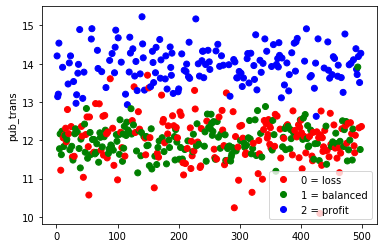

In [12]:
def scatterplot_kth_column(k, colors=["red", "green", "blue"]):
    scatter = plt.scatter(range(1, 500), x[:, k], c=y, cmap=ListedColormap(colors))
    plt.ylabel(features_names[k])
    plt.legend(handles=scatter.legend_elements()[0], labels=CLASSES)

    return scatter

scatterplot_kth_column(0)

We observe a clustering of the data with respect to its classes, which we color-coded by RBG (see legend). We conclude that the _pub_trans_ feature is relevant.

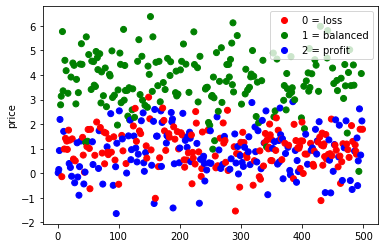

In [13]:
scatterplot_kth_column(1)

We observe a clustering of the data with respect to its classes, which we color-coded by RBG. We conclude that the _price_ feature is relevant. This also makes intuitive sense, that the price will play a role in the success of the companies sales.

_Note: Since the data is artificially generated, of course a negative price makes no sense._

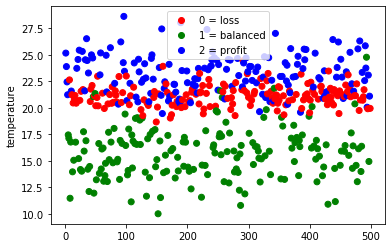

In [14]:
scatterplot_kth_column(2)

We observe a clustering of the data with respect to its classes, which we color-coded by RBG. We conclude that the _temperature_ feature is relevant. This also makes intuitive sense, that the temperature might determine how often people are outside and hence use an E-Scooter, which translates to a companies success in sales. For example: One might not want to start an E-Scooter company in Siberia.

_Note: The data is artificial, the most loss seems to be made at around 20-22.5 degrees Celsius. Fair and rather cold weather (i.e. below 17.5 degrees Celsius) still makes balanced profit._

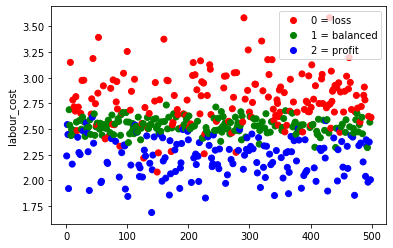

In [15]:
scatterplot_kth_column(9)

We observe a clustering of the data with respect to its classes, which we color-coded by RBG. We conclude that the _labour_cost_ feature is relevant. This also makes intuitive sense, that the labour cost plays a role in the companies success. If the labour costs are low, the company is more likely to make a profit than with high labour costs, this is also reflected in the graph above.

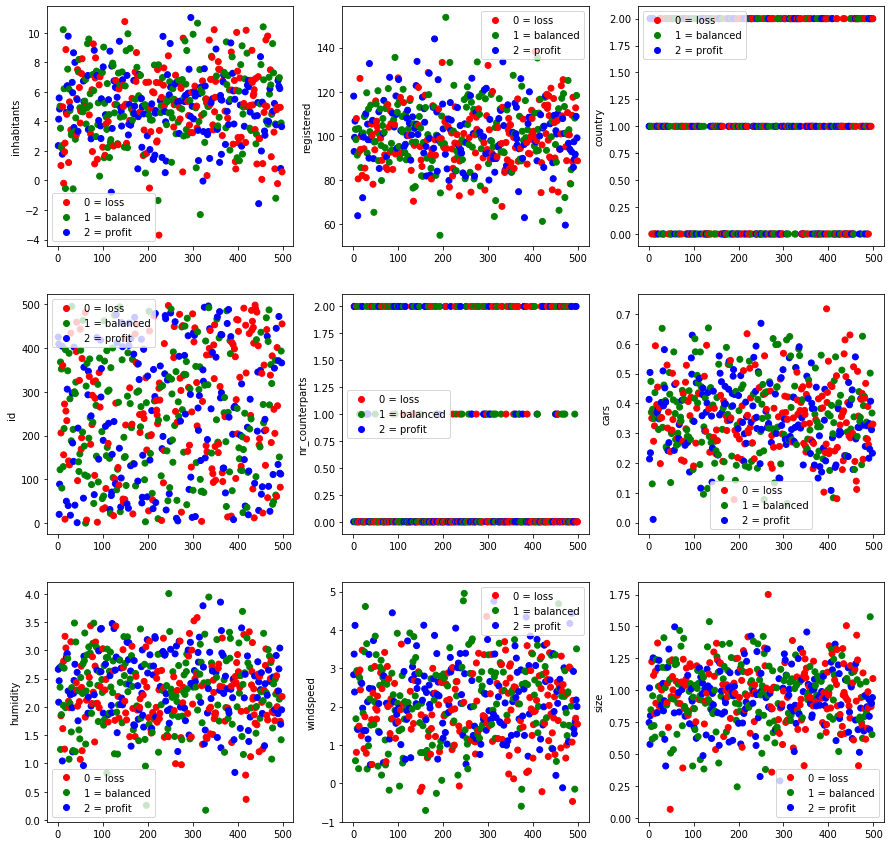

In [16]:
fig = plt.figure(figsize=(15, 15))

for k, feature in enumerate([3, 4, 5, 6, 7, 8, 10, 11, 12]):  # scatterplots for some other features
    plt.subplot(3, 3, k+1)
    scatterplot_kth_column(feature)

The plots above show a much more _chaotic_ behaviour of the data. There is no apparent relationship between the classes and the features. For now we shall consider them as _rather irrelevant_.

We still need to discuss whether the feature 'country' is relevant or not. We shall do this by the means of counting:

In [17]:
def counting(number):
    """
    A naive counting function which helps us determine whether a given country is successful in sales or not. 
    It does so by counting the instances of loss, balanced and profit classes for each country.
    Usage: 0 = Austria, 1 = Germany, 2 = Switzerland.
    """
    
    country_name = ordinalEnc.inverse_transform([[number,0,0]])[0,0]  # the two zeros after number are not important, they will give the first id and first number of counterparts
    
    count = np.bincount(y[x[:, 5] == number])
    
    print(country_name, "has:", count[0], "instances of loss", count[1], "instances of balanced and", count[2], "instances of profit")

for i in (0,1,2): 
    counting(i)

Austria has: 59 instances of loss 62 instances of balanced and 49 instances of profit
Germany has: 54 instances of loss 56 instances of balanced and 57 instances of profit
Switzerland has: 55 instances of loss 58 instances of balanced and 49 instances of profit


Our analysis suggest that the country feature is also irrelevant as the instances of loss/balance/profit is evenly spread among the three countries. This makes intuitive sense: If a E-Scooter company is successful in one of the three neighbour countries Austria, Germany, Switzerland then it should also be successful in the other two. 

On top of the visual (statistical) analysis we've carried out so far, we shall incorporate an _f-test_ in order to further see which of the features are relevant or not:

In [18]:
selector = SelectKBest(score_func=f_classif, k="all")
selection = selector.fit(x, y)
print(f"{'Feature name':<17}Score")
for feature_name, score in zip(features_names, selection.scores_):
    print(f"{feature_name:<17}{score}")

Feature name     Score
pub_trans        838.7327211156739
price            507.97390601771116
temperature      741.9405923087922
inhabitants      0.3797211844807062
registered       0.9311583750278856
country          0.043267894972736455
id               0.9733206062013445
nr_counterparts  0.48818426449611024
cars             0.23499639468285957
labour_cost      380.0286669426751
humidity         2.4577930386538798
windspeed        2.883947910173691
size             1.2846730121640408


In conjunction with our visual statistical analysis the _f-test_ confirms our hypothesis of relevant respectively irrelevant features.

Evidently, not all features are relevant and we might as well _'forget'_ about them. We recall our features and mark them as relevant respectively irrelevant according to our observations above:

		pub_trans: public transport index (relevant)
		price: price to rent per km (relevant)
		temperature: average tempereture during summer (relevant)
		inhabitants: number of inhabitants (irrelevant)
		registered: number of registered users in thousand (irrelevant)
		country: country (irrelevant)
		id: internal dataset code (irrelevant)
		nr_counterparts: nr_counterparts (irrelevant)
		cars: number of cars per inhabitant (irrelevant)
		labour_cost: average labour cost in thousand per month (relevant)
		humidity: absolute humidity in g/m3 (relevant) [maybe only a slight relevance]
		windspeed: average wind speed in km/h (relevant) [maybe only a slight relevance]
		size: size of city center in km2 (irrelevant)
		class: profitability (0 = loss, 1 = balanced, 2 = profit) <--- LABEL TO PREDICT !!!

In accordance with our observations, we limit ourselves to the following features:

In [19]:
CHOSEN_FEATURES = [0,1,2,9,10,11]
X = x[:, CHOSEN_FEATURES]
features_names = features_names[CHOSEN_FEATURES]

In [20]:
print("New features: \n", features_names)
print("The first row now looks like this: \n", X[0,:])

New features: 
 ['pub_trans' 'price' 'temperature' 'labour_cost' 'humidity' 'windspeed']
The first row now looks like this: 
 [1.42026351e+01 1.90186463e-02 2.51751307e+01 2.23781367e+00
 2.66531063e+00 2.83177019e+00]


## Shuffling and data train/test splitting

### Shuffling

We know that usually datapoints in a sample are not realizations of a perfectly _i.i.d. sequence of random variables_. Instead, the sample might be generated in such a way that the datapoints have some degree of time dependence without us noticing, or they might be correlated in some other way among each other. Generally speaking, we might not want to _trust_ the data as it is distributed to us, since we do not know in what way it was gathered (dependencies and so on).

Moreover, some algorithms may depend on the order of the datapoints in the sample.

In order to reduce these efffects as much as possible,it is always a good idea to __shuffle__ the datapoints before usage.

### Data splitting for training and testing purposes

To obtain a result of how good our model will be we cannot plainly use the empirical error obtained on the training dataset. This error is biased as we trained the model in such a way as to minimize it!

Instead, one typically would like to compute the empirical error on new, previously __unseen__ data to obtain a better estimate of how good the model describes reality. These "new, previously unseen" data __must be set aside from the beginning and separated from the training dataset__ into a test dataset.

The test dataset __will not be used for training__ and we will __use it only at the end__, in order to come up with an estimate of how good our model is.


Using Scikit learn, the notion of train/test/validation splitting and shuffling can be implemented as follows:

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, shuffle=True, random_state=1)
print("The X and y training sets have the shape: \n", X_train.shape, y_train.shape)
print("The X and y testing sets have the shape: \n", X_test.shape, y_test.shape)

The X and y training sets have the shape: 
 (374, 6) (374,)
The X and y testing sets have the shape: 
 (125, 6) (125,)


# Model implementations

One of the models we must implement (according to the project description) is the random forest model.

#### Todo: Am Ende kommt hier alles aus RandomForestImplementation rein

# Initializing the Models

Our implementation of the RandomForest algorithm already natively supports multiple labels:

In [22]:
forest_multi_classif = RandomForestClassifier(n_estimators=10, random_state=2)

We have also implemented a class *OneVsOneClassifier* which makes it easy to perform OneVsOne classification with any classification estimator.

_Note: In a One vs One classification we perform $k(k-1)/2$ binary classifications, each of which discriminates between a pair of classes. In more detail, fix $i,j∈\{1,…,k\}$ and perform a binary classification between all the data points with label either $i$ or $j$. Finally, the multiclass classifier predicts by using the label with the highest number of "wins". We have been introduced to this approach in the exercise classes (Class 12) and decided to use this reduction algorithm rather than One Vs All because:_
+ We work on a small data set.
+ One vs All often creates an imbalance in the data set (for example, more data with labels $\{1,2\}$ combined exist than data with label $\{0\}$).
+ In One vs All, the scale of the confidence values may differ between the binary classifiers.
+ One vs One seems more intuitive to us.

In [23]:
forest_classif = OneVsOneClassifier(RandomForestClassifier, n_classes=3, n_estimators=10, random_state=3) #Random Forest with OneVsOne

Next we shall implement a variety of (classical) machine learning algorithms provided by scikit-learn. Note that since we are not allowed to use a multiclass classification approach directly (except for the random forest) we must first turn our multiclass classification problem into a binary classification problem. We can easily achieve this by using our OneVsOneClassifier routine.

## Logistic regression

In the exercise classes (Class 5), logistic regression was the first classification model we have been exposed to. Logistic regression is a fundamental model that can be used to solve binary classification models and it is conceptually close to linear regression. For more information see [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) on the sklearn website.

In [24]:
logreg_classif = LogisticRegression(multi_class ="ovr", solver='lbfgs', random_state=4)  # note that the Logistic Regression is by default a OneVsRest algorithm

## Multilayer perceptron

A multilayer perceptron (MLP) is a class of feedforward artificial neural network (ANN). We have encountered neural networks and the MLP in the exercise classes (Class 11). An *artificial neural network* (ANN) is a model of computation inspired by the structure of neural networks in the brain. It can be described as a directed graph whose nodes correspond to neurons and edges correspond to links between them, where each neuron receives as input a weighted sum of the outputs of the neurons connected to its incoming edges, and has an activation according to this input. In a *feedforward* neural network the underlying graph does not contain cycles. For more information see [Multilayer perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) on the sklearn website.

In [25]:
MLP_classif = OneVsOneClassifier(MLPClassifier, n_classes=3, learning_rate="invscaling", random_state=5)

## $k$-nearest neighbours

In the exercise classes (class 10) we've seen the $k$-nearnest neighbour algorithm. The $k$-nearest neighbour algorithm is arguably one of the most simple classification algorithm existing. The general idea is to predict the label of a new datapoint according to the label(s) of the closest training point(s) to it. Intuitively, it is a good idea to simply decide the label of a newly observed datapoint according to the label of the closest given point in the training set. Considering only one neighbour would lead to some evident problems. The role of $k$ is that more neighbours means smoother boundary and smoother decision boundary corresponds to simpler model. On the other hand, the boundary for small values of $k$ gets very rough. Hence, the decision rule gets more complicated. Put differently, low $k$ corresponds to high model complexity and high $k$ corresponds to low model complexity. For more information see [$k$-nearest neighbours](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) on the sklearn website.

In [26]:
neighbors_classif = OneVsOneClassifier(KNeighborsClassifier, n_classes=3, random_state=6)

## Support vector machines

Another algorithm we have seen in the exercise classes (class 8) is the support vector machine (SVM). Roughly speaking, support vector machine constructs a hyperplane or set of hyperplanes in a high- or infinite-dimensional space, which can be used for classification, regression, or other tasks like outliers detection. Intuitively, a good separation is achieved by the hyperplane that has the largest distance to the nearest training-data point of any class (so-called functional margin), since in general the larger the margin, the lower the generalization error of the classifier. For more information see [Support Vector Machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) on the sklearn website.

In [27]:
svc_classif = SVC(gamma='scale', random_state=7)  # Note that the support vector machine is by default a OneVsOne algorithm

## Adaboost

AdaBoost, short for Adaptive Boosting, is a machine learning meta-algorithm formulated by Yoav Freund and Robert Schapire, who won the 2003 Gödel Prize for their work. It can be used in conjunction with many other types of learning algorithms to improve performance. Put differently, AdaBoost is a type of say *ensemble learning* where multiple learners are employed to create a stronger learning algorithm. AdaBoost works by choosing a base algorithm, for example decision trees, and gradually/iteratively improving said scheme by accounting for the incorrectly classified examples in the training set. For more information see [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) on the sklearn website.

In [28]:
adaboost_classif = OneVsOneClassifier(AdaBoostClassifier, n_classes=3, random_state=8)

## Bootstrap aggregating (bagging)

A Bagging classifier is an ensemble (meta-) estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Bagging is typically used when we want to reduce the variance (and helps to avoid overfitting) while retaining the bias. Bagging is most typically applied to decision tree models. For more information see [Bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) on the sklearn website.

In [29]:
bagging_classif = OneVsOneClassifier(BaggingClassifier, n_classes=3, random_state=9)

## Stochastic gradient descent

In the exercise classes (Class 3) we have seen the (batch) gradient descent method. Gradient Descent can be described as an iterative method which is used to find the values of the parameters of a function that minimizes the cost function as much as possible. A *stochastic* gradient descent refers to a process that is linked with a random probability. Thus, in Stochastic Gradient Descent (SGD), only a few samples are selected randomly instead of the whole data set (batch) for each iteration. For more information see [Stochastic gradient descent](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) on the sklearn website.

In [30]:
gradient_classif = SGDClassifier(random_state=10)  # note that the SGDClassifier is by default a OneVsRest algorithm

## Gaussian Process classifiers

Another stochastic machine learning algorithm is given by Gaussian processes. A Gaussian process is a classical process in probability theory and carries many nice properties with it, arguably the most famous example of a Gaussian process is a Brownian motion. In recent years Gaussian processes have received increased attention in the machine-learning community and we shall implement here the sk-learn implementation of the Gaussian process (classifier) for machine learning and then see how it performs. For more information see [Gaussian Process](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html) on the sklearn website.

In [31]:
gaussian_classif = OneVsOneClassifier(GaussianProcessClassifier, n_classes=3, random_state=11)

# Validation

We shall now test how our previously defined machine learning algorithms perform. To this extend we use $10$-fold cross-validation (CV) on the training dataset, this method was discussed in the exercise classes (Class 4):

In [32]:
all_classifiers = [forest_multi_classif, forest_classif, logreg_classif, neighbors_classif, svc_classif, adaboost_classif, 
                   bagging_classif, gradient_classif, gaussian_classif]
names = ["Multilabel forest", "OneVsOne forest", "Logistic regression", "OneVsOne KNeighbors", "Support Vector Machine",
         "OneVsOne AdaBoost", "OneVsOne Bagging", "Stochastic Gradient Descent", "OneVsOne Gaussian Process"]

In [33]:
scores = np.vstack([cross_val_score(classifier, X_train, y_train, cv=10) for classifier in all_classifiers])  # to speed up the process you can replace cv by a smaller number
scores_ = np.apply_along_axis(np.mean, axis=1, arr=scores)

In [34]:
print(f"{'Classifier':<30}Score")
print("------------------------------------")
for classifier_name, score in zip(names, scores_):
    print(f"{classifier_name:<30}{score:.4f}")
maximum = scores_.argmax()
print("\nThe maximal score is achieved by the classifier", names[maximum])

Classifier                    Score
------------------------------------
Multilabel forest             0.9491
OneVsOne forest               0.9518
Logistic regression           0.9334
OneVsOne KNeighbors           0.9543
Support Vector Machine        0.9386
OneVsOne AdaBoost             0.9437
OneVsOne Bagging              0.9491
Stochastic Gradient Descent   0.9068
OneVsOne Gaussian Process     0.9570

The maximal score is achieved by the classifier OneVsOne Gaussian Process


All algorithms except SGD perform with a cross-validation score of about $94$%-$96$%. Without fixed random_state, there is fairly little fluctuation in the scores of these classifiers. However, there is a relatively large fluctuation of the accuracy of SGD. This might be due to SGD being affected strongly by "luck" during training, as the gradient of the loss function is estimated with just a single sample on each iteration.

# Hyperparameter optimization for the random forest

As we have seen in the validation section, our algorithms already perform very well on the testing set with fairly little fluctuation. We shall now test whether hyperparameter optimization for the random forest yields a significant increase in its already appealing accuracy or not. We use scikit-learns [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) which provides an exhaustive search over specified parameter values for an estimator. We decide to optimize the parameters *n_estimators* and *max_depth*.

In [35]:
param_grid = {"n_estimators": np.arange(2, 10), "max_depth": np.append(np.arange(3, 8), np.Inf)}  # tune this to search over your favorite set of parameters
search = GridSearchCV(forest_multi_classif, param_grid, cv=3)
params = search.fit(X_train, y_train)

C:\Users\marco\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Let's see if this optimization yields for a better performance:

In [36]:
params.best_estimator_.get_params()
params.best_estimator_.score(X_test, y_test)

0.936

As we can see, there is no significant increase in performance due to hyperparameter optimization. 

__Hypothesis:__ We believe that the $y$-labels (which we want to predict) are given an initial noise which is independent of the given features. All predicators are very well capable to model the relationship between our $X$ and $y$ data but, due to noise, they yield wrong predicitions of the labels in approximately $5\%$ of the cases. In particular hyperparameter optimization, even of other parameters and different predicators will not improve our accuracy.

# Testing

We shall now see how our classifiers perform on the testing data set, recall that the testing data set is so far unseen by our algorithms, as we have set it aside from the beginning.

In [37]:
for classifier in all_classifiers:
    classifier.fit(X_train,y_train) ## Training our classifiers on the training sets.
    
scores2 = np.vstack([classifier.score(X_test, y_test) for classifier in all_classifiers])
scores2_ = np.apply_along_axis(np.mean, axis=1, arr=scores2)

print(f"{'Classifier':<30}Score")
print("------------------------------------")
for classifier_name, score2 in zip(names, scores2_):
    print(f"{classifier_name:<30}{score2:.4f}")
maximum = scores2_.argmax()
print("\nThe maximal score is achieved by the classifier", names[maximum])

Classifier                    Score
------------------------------------
Multilabel forest             0.9520
OneVsOne forest               0.9680
Logistic regression           0.9680
OneVsOne KNeighbors           0.9440
Support Vector Machine        0.9280
OneVsOne AdaBoost             0.9680
OneVsOne Bagging              0.9600
Stochastic Gradient Descent   0.7840
OneVsOne Gaussian Process     0.9600

The maximal score is achieved by the classifier OneVsOne forest


We notice a very good performance of our implemented algorithms on __unseen__ data. This performance stays about constant also if we drop the random_states.

# Conclusion

We have implemented a total of $9$ classifiers and studied their performance on previously unseen data. Interestingly, all classifiers perform extremely well with respect to their accuracy on the unseen data. We notice that the (direct) multiclass classification approach of the random forest tree only performs marginally better than its OneVsOne implementation. We achieve high accuracy despite the fact that we have reduced our initial dataset from $13$ features to only $6$ remaining features, we believe that this further shows that the features we have chosen are the most important ones. The authors of this Juypter Notebook are in particular very pleased with the fact that our own implementation of the random forest tree can compete with state of the art machine learning algorithms provided by scikit learn, which is a huge machine learning library for the Python programming language used by data enthusiasts and professionals alike. As the goal of this project was to find the best machine learning algorithm for the dataset assigned to us, we cannot give an exclusive answer. However, we noticed that during our experiments the random forest tree yields constant good performance over the $93\%$ accuracy threshold, whereas the SGD classifier has a large fluctuation in accuracy (around $70\%$ all the way up to $96\%$). Moreover, our experiments led us to hypothesize that the $y$-labels are given an initial noise which is independent of the given features. As a consequence of said inherited noise, all predicators are very well capable to model the relationship between our $X$ and $y$ data but they yield wrong predicitions of the labels in approximately $5\%$ of the cases. 